# Self-Supervised Learning (SSL)

In [1]:
import os
from tqdm import tqdm
from typing import Union
import numpy as np
# For interactive plotting:
import matplotlib.pyplot as plt
import ipywidgets as widgets
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass
try:
    %matplotlib widget
except:
    os.system('pip install ipympl -qq')
    %matplotlib widget


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2 as T
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

def t2img(x):
    # X: torch tensor of shape (C, H, W)
    # prepares the image for plotting
    return x.detach().moveaxis(0, -1).squeeze().cpu().numpy().clip(0, 1)

Device is cuda


## Dataset

In [2]:
dataset = CIFAR10(
    root = './CIFAR10',
    train = True,
    download = True,
    transform = T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
    )

Files already downloaded and verified


In [3]:
cifar10_classes = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# helper class to visualize image data interactively in Jupyter Notebook
class ImageDataViz:
    """
    An interactive image data visualzation tool inside Juptyer Notebook.
    Make sure to use the magic command: %matplotlib widget
    """
    def __init__(self, data: Dataset):
        self.data = data
        self.n_samples = len(data)
        self.index = widgets.IntSlider(
            value=0, 
            min=0, 
            max=self.n_samples-1, 
            step=1, 
            description='Index', 
            continuous_update=True,
            layout=widgets.Layout(width='60%'),
            )

    def update(self, index: int):
        x, y = self.data[index]
        self.img.set_data(t2img(x))
        self.ax.set_title(f'Label: {cifar10_classes[y]}')

    def show(self):
        self.fig, self.ax = plt.subplots()
        x, y = self.data[0]
        self.img = self.ax.imshow(t2img(x))
        self.ax.axis('off')
        self.ax.set_title(f'Label: {cifar10_classes[y]}')
        widgets.interact(self.update, index=self.index)

interactive(children=(IntSlider(value=0, description='Index', layout=Layout(width='60%'), max=49999), Output()…

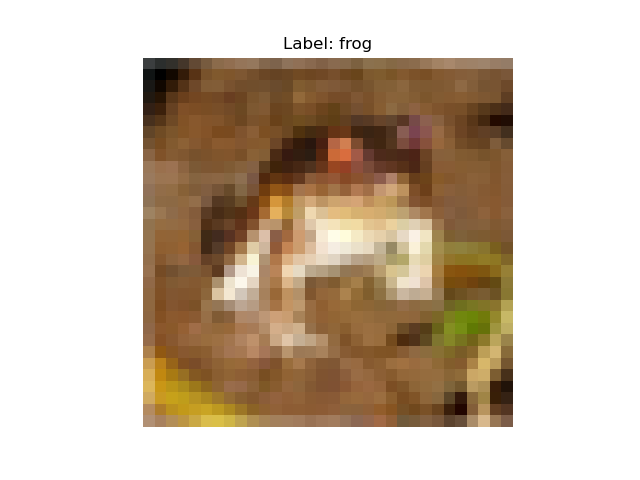

In [4]:
viz = ImageDataViz(dataset)
viz.show()

## Contrastive Learning

One popular self-supervised learning framework is contrastive learning. As suggested by the name, a neural network learns to contrast data pairs agaist each other. The dataset can be defined automatically by considering the output of some model for two augmentations of the same data as a _similar_ or _positive_ pair, and any other pair as _dissimilar_ or _negative_ pair. Let's implement a class for random augmentation of data, and visualize positive pairs. 

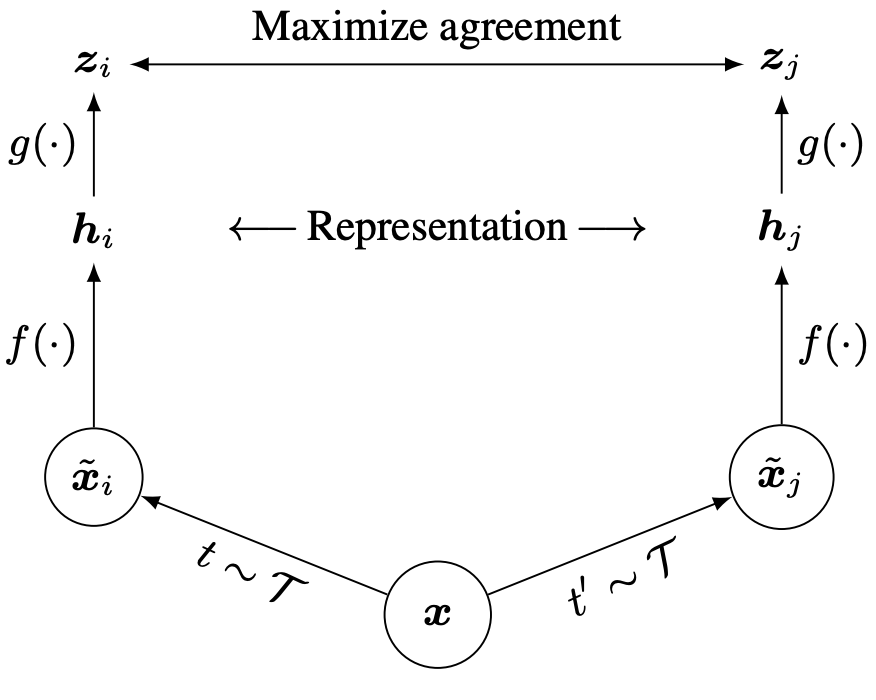

In [5]:
class Augment:
    """
    You can use a similar class to define a more flexible
    data augmentation pipeline and explore different options.
    """
    def __init__(
        self,
        img_size = 32,
        ):
    
        color_jitter = T.ColorJitter(
            brightness = 0.4,
            contrast = 0.4,
            saturation = 0.4,
            hue = 0.1,
            )
        
        blur = T.GaussianBlur(
            kernel_size = 3,
            sigma = (0.1, 2.0),
            )
        
        self.transform = T.Compose([
            T.RandomResizedCrop(size = img_size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(p = 0.5),
            T.RandomApply([color_jitter], p = 0.8),
            T.RandomApply([blur], p = 0.5),
            T.RandomGrayscale(p = 0.2),
        ])
    

    def __call__(self, x):
        return self.transform(x)


In [6]:
class PairViz:
    """
    An interactive image data visualzation tool inside Juptyer Notebook.
    Make sure to use the magic command: %matplotlib widget
    """
    def __init__(self, data: Dataset):
        self.data = data
        self.n_samples = len(data)
        self.index = widgets.IntSlider(
            value=0, 
            min=0, 
            max=self.n_samples-1, 
            step=1, 
            description='Index', 
            continuous_update=True,
            layout=widgets.Layout(width='60%'),
            )
        
        self.augment = Augment(img_size = 96)

    def update(self, index: int):
        x, y = self.data[index]
        x1, x2 = self.augment(x), self.augment(x)
        self.img0.set_data(t2img(x))
        self.img1.set_data(t2img(x1))
        self.img2.set_data(t2img(x2))
        self.ax0.set_title(f'Label: {cifar10_classes[y]}')
        self.ax1.set_title(f'Augmentation 1')
        self.ax2.set_title(f'Augmentation 2')

    def show(self):
        self.fig, (self.ax0, self.ax1, self.ax2) = plt.subplots(1, 3, figsize=(10, 5))
        x, y = self.data[0]
        x1, x2 = self.augment(x), self.augment(x)
        self.img0 = self.ax0.imshow(t2img(x))
        self.img1 = self.ax1.imshow(t2img(x1))
        self.img2 = self.ax2.imshow(t2img(x2))
        self.ax0.axis('off')
        self.ax1.axis('off')
        self.ax2.axis('off')
        self.ax0.set_title(f'Label: {cifar10_classes[y]}')
        self.ax1.set_title(f'Augmentation 1')
        self.ax2.set_title(f'Augmentation 2')
        widgets.interact(self.update, index=self.index)

interactive(children=(IntSlider(value=0, description='Index', layout=Layout(width='60%'), max=49999), Output()…

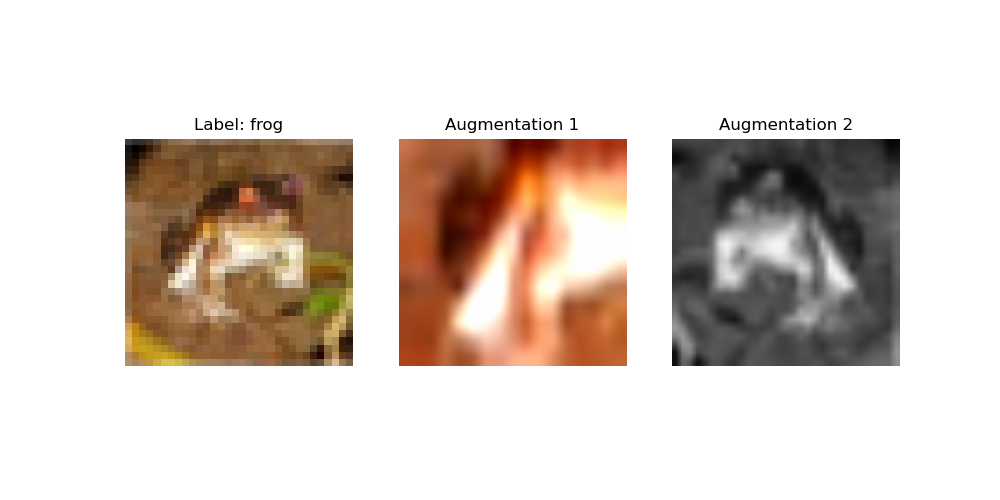

In [7]:
pair_viz = PairViz(dataset)
pair_viz.show()

## Train function

In [8]:
@torch.enable_grad()
def train_epoch_CL(
    model: nn.Module,
    train_loader: DataLoader,
    augment: Augment,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: str = Device,
    ):
    model.requires_grad_(True).train().to(device)
    losses = []
    for x, y in train_loader:

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Here is the new part:
        x1, x2 = augment(x), augment(x)
        z1, z2 = model(x1), model(x2)
        loss = loss_fn(z1, z2)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if torch.isnan(loss):
            raise ValueError('loss is nan')
        
        if torch.isinf(loss):
            raise ValueError('loss is inf')

    return losses
        

def train_CL(
    # Model and data
    model: nn.Module,
    train_data: Dataset,
    augment: Augment,
    loss_fn: nn.Module,
    device: str = Device,

    # Loss and optimizer
    optim_name: str = 'Adam', # from optim
    optim_config: dict = dict(),
    lr_scheduler_name: Union[str, None] = None, # from optim.lr_scheduler
    lr_scheduler_config: dict = dict(),

    # training settings:
    n_epochs: int = 10,
    batch_size: int = 32,
    ):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

    optimizer: optim.Optimizer = optim.__getattribute__(optim_name)(model.parameters(), **optim_config)

    if lr_scheduler_name is not None:
        lr_scheduler: optim.lr_scheduler._LRScheduler = optim.lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    epoch_pbar = tqdm(
        range(1, n_epochs+1),
        desc = 'epochs',
        unit = 'epoch',
        dynamic_ncols = True,
        leave = True,
        )
    
    epoch_losses = []
    batch_losses = []

    for epoch in epoch_pbar:

        losses = train_epoch_CL(
            model = model,
            train_loader = train_loader,
            augment = augment,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device,
            )

        batch_losses.extend(losses)
        epoch_losses.append(np.mean(losses))

        if lr_scheduler_name == 'ReduceLROnPlateau':
            lr_scheduler.step(epoch_losses[-1])
        elif lr_scheduler_name is not None:
            lr_scheduler.step()

        epoch_pbar.set_postfix_str(f'loss: {epoch_losses[-1]:.4f}')

    return epoch_losses, batch_losses

## Training

We run the training using the Resnet-18 as the backbone, and replace its final fully connected layer with our custom projection module (which we are going to discard after pre-training).

In [9]:
model = resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
model.fc = nn.Sequential(
    nn.Linear(512, 128, bias=False),
    nn.ReLU(),
    nn.Linear(128, 64, bias=False),
    )

For now, let's try to make the outputs for a positive pair close by minimizing the MSELoss between them. Can you guess what might go wrong?

In [11]:
train_config = dict(
    optim_name = 'Adam',
    optim_config = dict(lr=1e-3),
    lr_scheduler_name = 'ReduceLROnPlateau',
    lr_scheduler_config = dict(patience=5, factor=0.2),

    n_epochs = 2,
    batch_size = 256,
    )

epoch_losses, batch_losses = train_CL(
    model = model,
    train_data = dataset,
    augment = Augment(),
    loss_fn = nn.MSELoss(), # Not a good choice for contrastive learning
    device = Device,
    **train_config,
    )


epochs: 100%|██████████| 2/2 [00:29<00:00, 14.63s/epoch, loss: 0.0000]


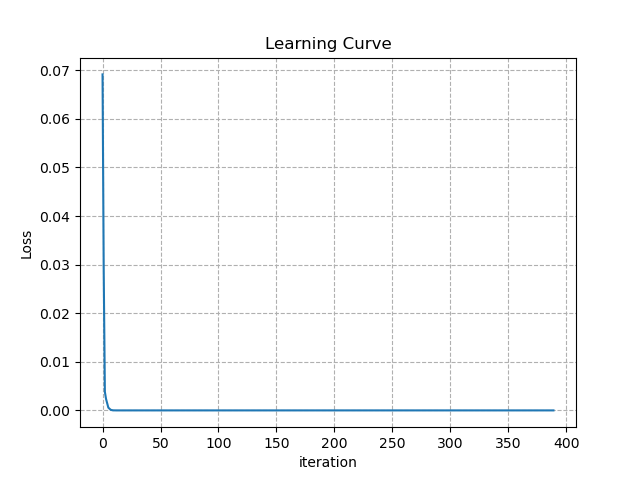

In [12]:
plt.figure()
plt.plot(batch_losses)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid(linestyle='--')
plt.show()

As you can see, it seems very easy for the model to optimize this loss. That is because it can minimize the MSE loss between any two outputs by just outputting the same thing, or just zeros for any input. Therefore, a better loss shuold be designed for contrastive learning. You will implement two loss functions in the assignment, and can use them in a successful contrastive learning task. 